In [ ]:
! hdfs dfs -mkdir -p /user/books

Данные берем отсюда - https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home

In [ ]:
! curl https://storage.yandexcloud.net/lsml-kosmos/books/goodreads_reviews_dedup.json.gz | gzip -d | tqdm | hdfs dfs -put - /user/books/reviews.json

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession, Row

sc = pyspark.SparkContext(appName="lsml-app-recomender")
se = SparkSession(sc)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-03-14 15:17:07,504 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2023-03-14 15:17:20,050 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2023-03-14 15:17:20,061 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpo

In [3]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALSModel

In [ ]:
df = se.read.json("/user/books/reviews.json")
df.write.parquet("/user/books/reviews.parquet")

In [4]:
df = se.read.parquet("/user/books/reviews.parquet")

In [5]:
df.limit(3).toPandas()

,book_id,date_added,date_updated,n_comments,n_votes,rating,read_at,review_id,review_text,started_at,user_id
0,12640991,Sat Jun 07 11:44:57 -0700 2014,Sat Jun 07 12:09:55 -0700 2014,0,0,5,Sat Jun 07 12:09:55 -0700 2014,69cb3a13a74940783922ab1c8bb7c387,Those crazy customers! What will they say next?,Sat Jun 07 00:00:00 -0700 2014,6365d62d4242a3ca3081be8cada855d3
1,1028357,Mon Jun 02 16:20:38 -0700 2014,Mon Jun 02 16:21:20 -0700 2014,0,0,5,,7198ba82abc0a2e8afe10b1d1f223356,an elegant little book with sweet sepia photog...,,6365d62d4242a3ca3081be8cada855d3
2,2506264,Mon Jun 02 16:17:09 -0700 2014,Mon Jun 02 16:17:45 -0700 2014,0,0,5,,46d10c142cc7b80232110f4bb3898a93,Lucy's lemon bars are luscious!,,6365d62d4242a3ca3081be8cada855d3


# ALS

Идентификаторы user и item должны быть числами

In [6]:
stringIndexer = StringIndexer(
    inputCol="user_id", 
    outputCol="user_id_idx"
)
modelIndexer = stringIndexer.fit(df)

In [7]:
df_idx = modelIndexer.transform(df)

In [8]:
df_idx.limit(5).toPandas()

2023-03-14 15:21:14,483 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB


,book_id,date_added,date_updated,n_comments,n_votes,rating,read_at,review_id,review_text,started_at,user_id,user_id_idx
0,12640991,Sat Jun 07 11:44:57 -0700 2014,Sat Jun 07 12:09:55 -0700 2014,0,0,5,Sat Jun 07 12:09:55 -0700 2014,69cb3a13a74940783922ab1c8bb7c387,Those crazy customers! What will they say next?,Sat Jun 07 00:00:00 -0700 2014,6365d62d4242a3ca3081be8cada855d3,39431.0
1,1028357,Mon Jun 02 16:20:38 -0700 2014,Mon Jun 02 16:21:20 -0700 2014,0,0,5,,7198ba82abc0a2e8afe10b1d1f223356,an elegant little book with sweet sepia photog...,,6365d62d4242a3ca3081be8cada855d3,39431.0
2,2506264,Mon Jun 02 16:17:09 -0700 2014,Mon Jun 02 16:17:45 -0700 2014,0,0,5,,46d10c142cc7b80232110f4bb3898a93,Lucy's lemon bars are luscious!,,6365d62d4242a3ca3081be8cada855d3,39431.0
3,17276206,Mon Jun 02 16:13:47 -0700 2014,Mon Jun 02 16:14:29 -0700 2014,0,0,5,Tue Jun 03 00:00:00 -0700 2014,084c25847c45ac89ab94d7bc461a2ee2,"the pictures and the recipes are superb, and y...",,6365d62d4242a3ca3081be8cada855d3,39431.0
4,2433240,Mon Jun 02 15:57:42 -0700 2014,Wed Jul 02 16:08:58 -0700 2014,0,0,5,Mon Jun 02 15:57:59 -0700 2014,e00d5c22b5d8cfc20050b287bd0b0854,A charming addition to any home.,,6365d62d4242a3ca3081be8cada855d3,39431.0


In [9]:
(
    df_idx
    .select(
        df_idx.book_id.cast("integer"), 
        df_idx.user_id_idx.cast("integer"),
        df_idx.rating.cast("float")
    )
    .limit(2)
    .toPandas()
)

2023-03-14 15:22:15,290 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.4 MiB


,book_id,user_id_idx,rating
0,12640991,39431,5.0
1,1028357,39431,5.0


In [10]:
train_df, test_df = (
    df_idx
    .select(
        df_idx.book_id.cast("integer"), 
        df_idx.user_id_idx.cast("integer"),
        df_idx.rating.cast("float")
    )
    .randomSplit([0.8, 0.2], 874365)
)

In [11]:
train_df.count()

2023-03-14 15:22:34,616 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB


12593264

In [12]:
train_df = train_df.cache()
test_df = test_df.cache()

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html#pyspark.ml.recommendation.ALS

In [13]:
alsModel = ALS(
    rank=20,
    userCol='user_id_idx',
    itemCol='book_id',
    ratingCol='rating'
)

In [14]:
model = alsModel.fit(train_df)

2023-03-14 15:24:07,807 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:24:10,747 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:24:36,275 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:24:49,234 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:24:58,559 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:25:08,754 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:25:14,380 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:25:16,821 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:25:24,752 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:25:29,080 WARN scheduler.DAGScheduler: Broadcasting large t

In [15]:
model

ALSModel: uid=ALS_914e8fc4be08, rank=20

In [16]:
predictions = model.transform(test_df)

In [17]:
predictions.select(
    "book_id", "user_id_idx", "rating",
    F.when(F.isnan(F.col("prediction")), 2.5).otherwise(F.col("prediction")).alias("prediction")
).limit(10).toPandas()

2023-03-14 15:30:34,374 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:30:34,761 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:30:35,190 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:30:50,973 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB
2023-03-14 15:31:30,225 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB


,book_id,user_id_idx,rating,prediction
0,463,25463,2.0,2.125897
1,463,78145,5.0,4.014388
2,463,2052,5.0,3.549244
3,463,14864,3.0,3.587353
4,463,5822,4.0,2.505881
5,463,28536,4.0,3.418390
6,496,118183,5.0,2.500000
7,1591,5592,3.0,2.334067
8,1591,12492,4.0,2.733440
9,1591,8873,5.0,4.082526


In [18]:
predictions = predictions.select(
    "book_id", "user_id_idx", "rating",
    F.when(F.isnan(F.col("prediction")), 2.5).otherwise(F.col("prediction")).alias("prediction")
).cache()

In [19]:
rsme = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='rating',
    metricName='rmse'
).evaluate(predictions)

2023-03-14 15:32:30,587 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:32:31,043 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:32:31,449 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:32:39,859 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB
2023-03-14 15:33:17,049 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB
2023-03-14 15:34:30,784 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB


In [20]:
rsme

1.2571986175823344

In [21]:
rtwo = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='rating',
    metricName='r2'
).evaluate(predictions)

2023-03-14 15:34:35,498 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB
2023-03-14 15:35:40,307 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB


In [22]:
rtwo

-0.0003574318874415283

---

In [ ]:
alsModel = ALS(
    rank=150,
    userCol='user_id_idx',
    itemCol='book_id',
    ratingCol='rating'
)
model = alsModel.fit(train_df)
predictions = model.transform(test_df)
predictions = predictions.select(
    "book_id", "user_id_idx", "rating",
    F.when(F.isnan(F.col("prediction")), 2.5).otherwise(F.col("prediction")).alias("prediction")
).cache()

rsme = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='rating',
    metricName='rmse'
).evaluate(predictions)
print(rsme)
rtwo = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='rating',
    metricName='r2'
).evaluate(predictions)
print(rtwo)

In [ ]:
model.save("/user/books/als-150")

In [23]:
model = ALSModel().load("/user/books/als-150")

In [24]:
predictions = model.transform(test_df).select(
    "book_id", "user_id_idx", "rating",
    F.when(F.isnan(F.col("prediction")), 2.5).otherwise(F.col("prediction")).alias("prediction")
).cache()

In [25]:
predictions.limit(3).toPandas()

2023-03-14 15:37:56,465 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:38:17,035 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:38:55,793 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB


,book_id,user_id_idx,rating,prediction
0,463,25463,2.0,3.088337
1,463,78145,5.0,3.517526
2,463,28536,4.0,3.943266


In [26]:
rtwo = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='rating',
    metricName='r2'
).evaluate(predictions)
print(rtwo)

2023-03-14 15:38:57,254 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB
2023-03-14 15:40:25,945 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.5 MiB


0.018213869782585435


# VW

Обучать ALS по формулам не сильно сложнее линейной модели. При этом размерность очень высокая.
Поэтому создатели Vowpal Wabbit не прошли мимо и сделали факторизацию на базе vw.

In [27]:
def convert_to_vw(data):
    target = data['rating']
    
    book_id = data['book_id']
    user_id = data['user_id_idx']
    
    template = "{target} |u {user} |i {item}"
    return template.format(
        target=target,
        user=user_id,
        item=book_id
    )

In [28]:
! hdfs dfs -rm -r /user/books/train.vw /user/books/test.vw

Deleted /user/books/train.vw
Deleted /user/books/test.vw


In [29]:
train_df.rdd.map(convert_to_vw).saveAsTextFile('/user/books/train.vw')
test_df.rdd.map(convert_to_vw).saveAsTextFile('/user/books/test.vw')

2023-03-14 15:44:04,282 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB
2023-03-14 15:44:40,001 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 26.6 MiB


In [30]:
! hdfs dfs -cat /user/books/train.vw/* > books.train.vw
! hdfs dfs -cat /user/books/test.vw/* > books.test.vw

In [31]:
! head -n 5 books.train.vw

5.0 |u 4601 |i 1
5.0 |u 6090 |i 1
4.0 |u 9713 |i 1
5.0 |u 9934 |i 1
2.0 |u 15455 |i 1


In [32]:
! vw --final_regressor books.model.bin books.train.vw \
    --bit_precision 18 \
    --learning_rate 0.015 \
    -q ui \
    --rank 30 \
    --passes 20 \
    --cache -k 

creating quadratic features for pairs: ui 
final_regressor = books.model.bin
Num weight bits = 18
learning rate = 0.015
initial_t = 1
power_t = 0.5
decay_learning_rate = 1
creating cache_file = books.train.vw.cache
Reading datafile = books.train.vw
num sources = 1
Enabled reductions: rank, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
23.809454 23.809454            1            1.0   5.0000   0.1205       63
23.126781 22.444107            2            2.0   5.0000   0.2625       63
20.585162 18.043544            4            4.0   5.0000   0.3285       63
15.722990 10.860818            8            8.0   5.0000   0.4103       63
14.714807 13.706624           16           16.0   5.0000   0.4450       63
15.790171 16.865536           32           32.0   5.0000   0.5353       63
15.296687 14.803202           64           64.0   4.0000   0.7943       63
13.538872 11.781057          12

In [33]:
! vw --testonly --initial_regressor books.model.bin --predictions books.preductions.txt books.test.vw

creating quadratic features for pairs: ui 
only testing
predictions = books.preductions.txt
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = books.test.vw
num sources = 1
Enabled reductions: rank, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.973979 0.973979            1            1.0   5.0000   4.0131       63
0.891001 0.808023            2            2.0   3.0000   3.8989       63
0.718283 0.545564            4            4.0   5.0000   3.9561       63
1.440387 2.162492            8            8.0   2.0000   3.9782       63
1.146450 0.852513           16           16.0   5.0000   4.0221       63
1.207636 1.268822           32           32.0   4.0000   3.7922       63
1.228613 1.249590           64           64.0   5.0000   3.8065       63
1.590630 1.952647          128          128.0   4.0000   3.7144       63
1.597280 1.60

In [34]:
import numpy as np
from sklearn.metrics import r2_score


def calc_r2(predictions_filename, answers_filename):
    def read_target_from_vw(vw_record):
        return float(vw_record.split(' ')[0])
    
    with open(predictions_filename, 'r') as f:
        y_pred = np.array([float(value) for value in f.readlines()])
        
    with open(answers_filename, 'r') as f:
        y_expected = np.array([read_target_from_vw(value) for value in f.readlines()])
        
    return r2_score(y_expected, y_pred)

In [35]:
calc_r2('books.preductions.txt', 'books.test.vw')

0.013306889694614688

In [38]:
model.userFactors.limit(5).toPandas()

,id,features
0,5,"[-0.07720393687486649, -0.03092358633875847, -..."
1,15,"[-0.06538841128349304, -0.08368418365716934, -..."
2,25,"[-0.03245057165622711, 0.10539549589157104, -0..."
3,35,"[0.010047990828752518, -0.10455098003149033, -..."
4,45,"[0.04023910313844681, -0.1822228878736496, -0...."


In [39]:
model.itemFactors.limit(5).toPandas()

,id,features
0,10,"[-0.2850845456123352, 0.07771358639001846, -0...."
1,30,"[0.005825348664075136, -0.05510112643241882, -..."
2,40,"[0.050969891250133514, -0.0017147120088338852,..."
3,50,"[-0.10132698714733124, -0.13968558609485626, -..."
4,80,"[-0.03349057212471962, 0.04379903897643089, -0..."


In [ ]:
user_factors = model.userFactors.withColumnRenamed("features", "features_users").withColumnRenamed("id", "user_id")
item_factors = model.itemFactors.withColumnRenamed("features", "features_items").withColumnRenamed("id", "item_id")

train_embeddinds = (
    train_df
    .join(
        user_factors, 
        train_df["user_id_idx"] == user_factors['user_id'], 
        'inner'
    ).join(
        item_factors,
        train_df["book_id"] == item_factors['item_id'],
        'inner'
    ).select("rating", "features_users", "features_items")
)

test_embeddinds = (
    test_df
    .join(
        user_factors, 
        test_df["user_id_idx"] == user_factors['user_id'], 
        'inner'
    ).join(
        item_factors,
        test_df["book_id"] == item_factors['item_id'],
        'inner'
    ).select("rating", "features_users", "features_items")
)

In [ ]:
train_df

In [ ]:
train_df.write.csv('/user/books/train.1.csv')
test_df.write.csv('/user/books/test.1.csv')

In [ ]:
user_factors.write.json("/user/books/user_embeddings.json")
item_factors.write.json("/user/books/item_embeddings.json")

In [ ]:
! hdfs dfs -cat /user/books/train.1.csv/* > train.csv
! hdfs dfs -cat /user/books/test.1.csv/* > test.csv
! hdfs dfs -cat /user/books/user_embeddings.json/* > user_embeddings.json
! hdfs dfs -cat /user/books/item_embeddings.json/* > item_embeddings.json

In [ ]:
! hdfs dfs -cat /user/books/train.1.csv/* | hdfs dfs -put - s3a://lsml-kosmos/books/train.csv
! hdfs dfs -cat /user/books/test.1.csv/* | hdfs dfs -put - s3a://lsml-kosmos/books/test.csv
! hdfs dfs -cat /user/books/user_embeddings.json/* | hdfs dfs -put - s3a://lsml-kosmos/books/user_embeddings.json
! hdfs dfs -cat /user/books/item_embeddings.json/* | hdfs dfs -put - s3a://lsml-kosmos/books/item_embeddings.json

In [40]:
! head -n 1 user_embeddings.json

{"user_id":5,"features_users":[-0.07720394,-0.030923586,-0.04779837,0.3102566,-0.053540517,0.09795014,0.032852527,0.06930428,0.039828647,0.031232966,0.17347063,0.232285,-0.09380776,0.024341501,0.11624159,-0.2619187,-0.08836968,0.06953201,0.20723261,0.12196311,0.1247963,-0.10602624,-0.1254682,-0.28474677,-0.01585786,-0.120135166,0.07127104,-0.21951209,-0.30859768,0.096185505,0.111323744,-0.036068693,-0.14755586,0.06521902,0.04360454,0.104903206,-0.045897838,-0.10819084,-0.030722907,0.07432675,-0.073400036,-0.32423452,-0.15359992,0.26965234,-0.29423082,-0.13540295,-0.039831333,-0.2589557,-0.14539984,0.067690015,0.01251732,-0.08975892,-0.3184666,0.12576434,-0.19654253,0.2511444,-0.015817294,0.20824127,-0.09050013,0.22162919,-0.08456694,0.23965225,-0.08829764,-0.3244229,-0.062211625,0.19281957,0.29111478,0.096435584,0.08684807,0.13913643,0.28351086,0.08623802,-0.1467635,-0.018381469,0.008369594,0.028563906,0.1692092,-0.19120657,-0.11601393,0.07819555,0.20300296,0.42559722,-0.07550634,-0.11

In [41]:
import pandas as pd
import json
from tqdm import tqdm

In [42]:
train_pd_df = pd.read_csv('train.csv')
test_pd_df = pd.read_csv('test.csv')

In [ ]:
! mkdir -p user_embs/
! mkdir -p item_embs/

In [ ]:
with open('user_embeddings.json', 'r') as f:
    user_emb = {}
    for line in tqdm(f):
        r = json.loads(line)
        with open('user_embs/{}.json'.format(r['user_id']), 'w+') as g:
            g.write(json.dumps(r['features_users']))
    
with open('item_embeddings.json') as f:
    item_emb = {}
    for line in tqdm(f):
        r = json.loads(line)
        with open('item_embs/{}.json'.format(r['item_id']), 'w+') as g:
            g.write(json.dumps(r['features_items']))

# Recom NN

In [ ]:
torch.__version__

In [45]:
import torch

import json

import glob

import torch

import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.utils.prune as prune
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.linear import Linear
from torch.autograd import Variable

In [46]:
a, b, c = train_pd_df.iloc[3]

In [47]:
a, b, c

(1.0, 15455.0, 2.0)

In [ ]:
len(train_pd_df)

In [49]:
def get_user_emb(index):
    with open('user_embs/{}.json'.format(int(index))) as f:
        return json.loads(f.read())
    
def get_item_emb(index):
    with open('item_embs/{}.json'.format(int(index))) as f:
        return json.loads(f.read())

In [48]:
class BooksDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, idx):
        book, user, rating = self.df.iloc[idx]
        user_features = get_user_emb(user)
        book_features = get_item_emb(book)
    
        return rating, torch.FloatTensor(user_features), torch.FloatTensor(book_features)
    
    def __len__(self):
        return len(self.df)

In [50]:
BATCH_SIZE = 256

train_dataset = BooksDataset(train_pd_df)
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataset = BooksDataset(test_pd_df)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [51]:
class DSSMSimple(nn.Module):
    def __init__(self):
        super(DSSMSimple, self).__init__()
        
        self.ulin1 = nn.Linear(150, 100)
        self.ulin2 = nn.Linear(100, 50)

        self.blin1 = nn.Linear(150, 80)
        self.blin2 = nn.Linear(80, 50)
    
    def user_embedding(self, user):
        x = nn.ReLU()(self.ulin1(user))
        x = nn.ReLU()(self.ulin2(x))
        return x
    
    def book_embedding(self, book):
        x = nn.ReLU()(self.blin1(book))
        x = nn.ReLU()(self.blin2(x))
        return x
    
    def forward(self, user, book):
        user_x = self.user_embedding(user)
        book_x = self.book_embedding(book)
        return torch.einsum('bs,bs->b', user_x, book_x)

dssm = DSSMSimple()
print(dssm)

DSSMSimple(
  (ulin1): Linear(in_features=150, out_features=100, bias=True)
  (ulin2): Linear(in_features=100, out_features=50, bias=True)
  (blin1): Linear(in_features=150, out_features=80, bias=True)
  (blin2): Linear(in_features=80, out_features=50, bias=True)
)


In [52]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.MSELoss()
    model.train()
    for epoch in range(epoch_number):
        correct = 0
        for batch_idx, (y_batch, user_batch, book_batch) in enumerate(train_loader):
            var_user_batch = Variable(user_batch).float()
            var_book_batch = Variable(book_batch).float()
            var_y_batch = Variable(y_batch).float()
            
            output = model(var_user_batch, var_book_batch)

            optimizer.zero_grad()
            
            loss = error(output, var_y_batch)
            loss.backward()
            
            optimizer.step()

            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx*len(user_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data))

In [53]:
fit(dssm, train_dl, 1)

Epoch : 0 [0/12593263 (0%)]	Loss: 16.479763
Epoch : 0 [12800/12593263 (0%)]	Loss: 1.225606


KeyboardInterrupt: 

In [54]:
train_pd_df = train_pd_df.rename(columns={'1': 'book', '4601': 'user', '5.0': 'rating'})

In [55]:
users = train_pd_df['user'].unique().tolist()[:1000]
books = train_pd_df['book'].unique().tolist()[:100000]

In [56]:
len(users), len(books)

(1000, 100000)

In [57]:
import random
import numpy as np

In [59]:
rnd_user = random.choice(users)
rnd_book = random.choice(books)

print(rnd_user)
print(rnd_book)

189094
2871


In [60]:
user_emb = np.array(get_user_emb(rnd_user))
book_emb = np.array(get_item_emb(rnd_book))

In [61]:
score = user_emb.dot(book_emb)
score

3.39363445984638

# Bandits

In [62]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

In [63]:
model.itemFactors.limit(10).toPandas()

,id,features
0,10,"[-0.2850845456123352, 0.07771358639001846, -0...."
1,30,"[0.005825348664075136, -0.05510112643241882, -..."
2,40,"[0.050969891250133514, -0.0017147120088338852,..."
3,50,"[-0.10132698714733124, -0.13968558609485626, -..."
4,80,"[-0.03349057212471962, 0.04379903897643089, -0..."
5,100,"[-0.06785227358341217, 0.021136218681931496, -..."
6,110,"[-0.0590093620121479, 0.12813735008239746, -0...."
7,130,"[-0.004132889676839113, -0.005473628640174866,..."
8,160,"[-0.18580056726932526, -0.007518137339502573, ..."
9,180,"[-0.21777990460395813, -0.004085865803062916, ..."


In [64]:
books_embeddings = (
    se.createDataFrame(
        model
        .itemFactors
        .rdd.map(lambda x: (x.id, Vectors.dense(x.features))),
        ["id", "embedding"]
    )
).cache()

In [65]:
books_embeddings.select("id").distinct().count()

1856171

In [66]:
kmeans = KMeans(
    k=15,
    featuresCol="embedding",
    predictionCol="cluster_id"
)

In [67]:
clustering_model = kmeans.fit(books_embeddings)

2023-03-14 16:40:57,592 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2023-03-14 16:40:57,593 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [68]:
clustering_model

KMeansModel: uid=KMeans_945736c55f33, k=15, distanceMeasure=euclidean, numFeatures=150

In [69]:
books_clusters = clustering_model.transform(books_embeddings)

In [70]:
books_clusters.limit(10).toPandas()

,id,embedding,cluster_id
0,10,"[-0.2850845456123352, 0.07771358639001846, -0....",8
1,30,"[0.005825348664075136, -0.05510112643241882, -...",8
2,40,"[0.050969891250133514, -0.0017147120088338852,...",8
3,50,"[-0.10132698714733124, -0.13968558609485626, -...",12
4,80,"[-0.03349057212471962, 0.04379903897643089, -0...",4
5,100,"[-0.06785227358341217, 0.021136218681931496, -...",2
6,110,"[-0.0590093620121479, 0.12813735008239746, -0....",8
7,130,"[-0.004132889676839113, -0.005473628640174866,...",3
8,160,"[-0.18580056726932526, -0.007518137339502573, ...",7
9,180,"[-0.21777990460395813, -0.004085865803062916, ...",8


In [71]:
from collections import defaultdict

In [72]:
clusters = defaultdict(list)

In [73]:
for book_id, cluster_id in books_clusters.rdd.map(lambda x: (x["id"], x['cluster_id'])).collect():
    clusters[cluster_id].append(book_id)

In [74]:
class RecommenderBandit:
    def __init__(self, clusters, t):
        self.clusters = clusters
        self.book_map = {}
        
        for c, books in clusters.items():
            for b in books:
                self.book_map[b] = c
        
        self.params = {}
        self.t = t
        for c in clusters:
            self.params[c] = (1.0, 1.0)
        
    def get_book(self, user):
        best_cluster, prop = max([
            (c, np.random.beta(b, a))
            for c, (a, b) in self.params.items()
        ], key=lambda x: x[1])
        return random.choice(self.clusters[best_cluster])
    
    def observe(self, user, book, score):
        is_like = score > self.t
        cluster = self.book_map[book]
        a, b = self.params[cluster]
        if is_like:
            self.params[cluster] = (a, b+1)
        else:
            self.params[cluster] = (a+1, b)

In [75]:
class RecommenderRandom:
    def __init__(self, clusters):
        self.clusters = clusters
    
    def get_book(self, user):
        best_cluster = random.choice(list(self.clusters))
        return random.choice(self.clusters[best_cluster])
    
    def observe(self, user, book, score):
        pass

In [76]:
def play(number_of_rounds, user, recommender):
    scores = []
    for r in range(number_of_rounds):
        book = recommender.get_book(user)
        
        user_emb = np.array(get_user_emb(user))
        book_emb = np.array(get_item_emb(book))
        score = user_emb.dot(book_emb)
        recommender.observe(user, book, score)
        
        if r % 100 == 0:
            print("Round {}, book {}, score {}".format(r, book, score))
        
        scores.append(score)
    return scores

In [77]:
bandit = RecommenderBandit(clusters, 2.0)

In [78]:
random_rec = RecommenderRandom(clusters)

In [80]:
current_user = random.choice(users)

In [81]:
result_bandit = play(1000, current_user, bandit)

Round 0, book 34355050, score 2.007433047216707
Round 100, book 9523251, score 3.045932829077853
Round 200, book 25459447, score 3.1080206633121894
Round 300, book 35400310, score 3.106344004076624
Round 400, book 27821037, score 2.1865563120343463
Round 500, book 15700469, score 3.311572163126535
Round 600, book 13002123, score 3.5046401873773667
Round 700, book 25762893, score 3.229809361346439
Round 800, book 5800159, score 3.4891456327742807
Round 900, book 996347, score 4.191038055941544


In [82]:
result_bandit

[2.007433047216707,
 2.0116584276374256,
 3.882453536072294,
 3.583038922054875,
 1.4863391079405683,
 1.631006573619506,
 3.704393092993888,
 3.3242853395769587,
 2.0974045577649094,
 3.0470690683351616,
 2.0201860257240347,
 2.7376147346939583,
 2.87073736266633,
 3.228119057529924,
 3.0016689231294844,
 1.8941351086829936,
 2.023475061519957,
 2.8104114557863156,
 3.450592315317187,
 2.6918254877587593,
 3.339572314675534,
 2.4045844077997423,
 2.8178301561985646,
 3.4300370304735863,
 3.005227486266891,
 3.39004854157367,
 0.0,
 4.101905357361757,
 3.3337162099700492,
 3.6737392844548804,
 2.7280713592978842,
 2.808387456061984,
 2.2803688217239646,
 3.5529007390892904,
 3.242441112092485,
 3.0087890484879978,
 3.2479283681871207,
 3.2247984750766223,
 2.8488509320647513,
 3.279550070540063,
 3.82536038062802,
 1.8259126155288232,
 3.4913984504695397,
 2.351212101909935,
 3.6945039273742752,
 3.0341818920998187,
 3.7962613157260283,
 2.4207244297309134,
 3.087167417249163,
 2.88021

In [83]:
bandit.params

{8: (1.0, 296.0),
 12: (1.0, 255.0),
 4: (1.0, 7.0),
 2: (2.0, 1.0),
 3: (3.0, 6.0),
 7: (1.0, 91.0),
 9: (2.0, 22.0),
 0: (2.0, 4.0),
 6: (1.0, 260.0),
 14: (1.0, 7.0),
 1: (3.0, 1.0),
 11: (2.0, 1.0),
 5: (2.0, 51.0),
 10: (2.0, 1.0),
 13: (2.0, 1.0)}

In [84]:
from matplotlib import pyplot as plt

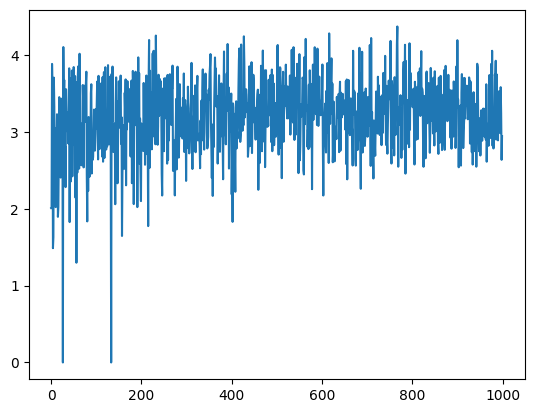

In [85]:
plt.plot(result_bandit)

In [86]:
result_ran = play(1000, current_user, random_rec)

Round 0, book 7229821, score 2.0943831837483446
Round 100, book 680144, score 2.8953228948851937
Round 200, book 34369027, score 2.467372617373934
Round 300, book 6921454, score 2.4785337301165615
Round 400, book 870484, score 3.3509742764182566
Round 500, book 16299334, score 1.5561035999223058
Round 600, book 32711684, score 2.4184427366302614
Round 700, book 1737078, score 2.5185747022083786
Round 800, book 16247826, score 3.288428233756427
Round 900, book 8697266, score 3.165536585724373


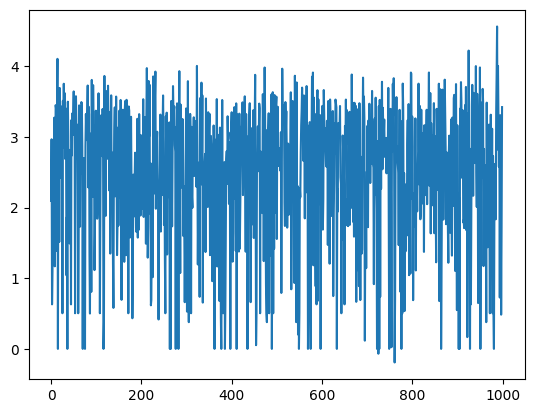

In [87]:
plt.plot(result_ran)